# En XGB modell för att estimera priset på en diamant

## 0. Importer

Först kommer alla importer som behövs för projektet.

In [1]:
import math
import os
from contextlib import redirect_stdout
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split

## 1. Förberedning av data

Vi börjar med att ladda in datasetet och ta bort en kolumn med index samt dubletter. Innan det sparar vi dock längden på datasetet för att senare veta hur mycket data som filtrerats bort. Vi kollar också på hur datasetet ser ut med .head() metoden.

In [2]:
df = pd.read_csv('diamonds.csv')

start_len = df.shape[0]

df.drop_duplicates(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

display(df.head())

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 1.1 Visualisering

Vi skapar några grafer för att visualisera datan.

Här skapas en funktion som jämför varje kolumn med priset och ritar en punkt för varje diamant. Vi kan hoppa över *cut*, *color* och *clarity* eftersom det är kategoriska.

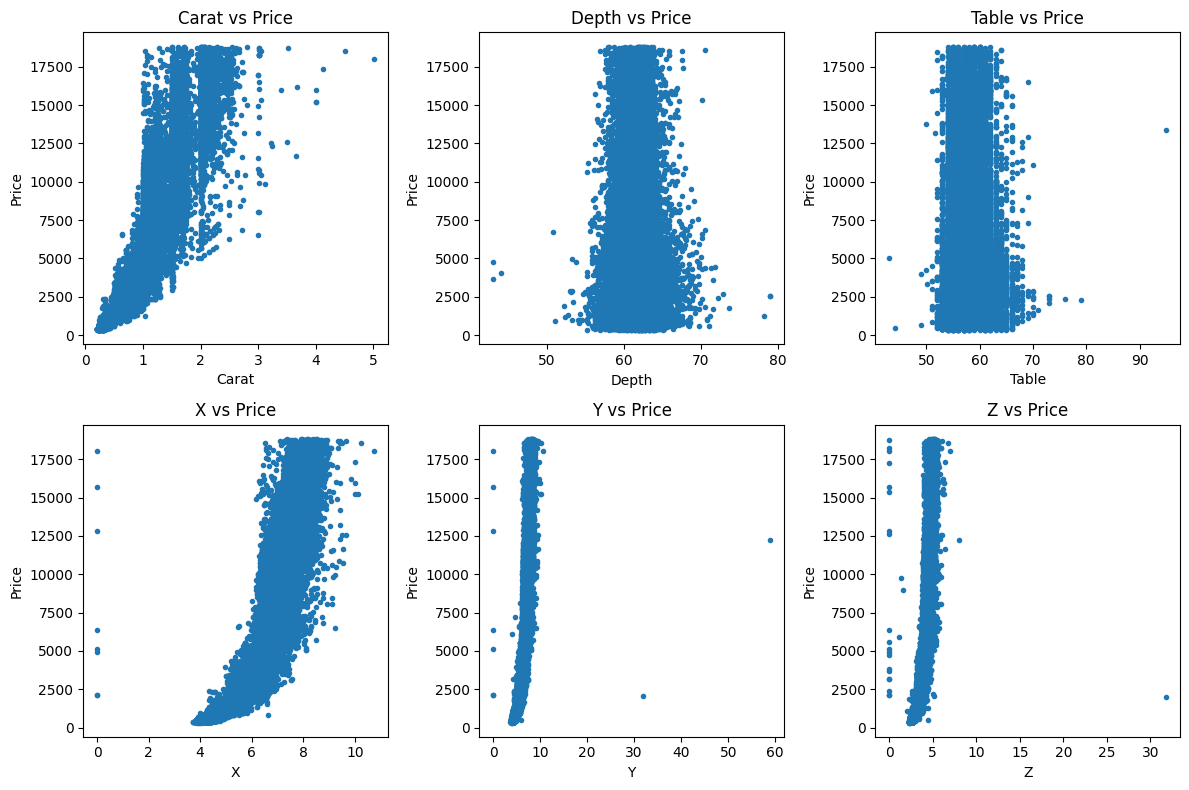

In [3]:
def plot_statistics():
    '''Rita en jämförelse mellan pris och alla andra kolumner'''

    plt.figure(figsize=(12, 8))
    for n, column in enumerate(df.drop(columns=['price', 'cut', 'color', 'clarity']).columns, 1):
        plt.subplot(2, 3, n)
        plt.scatter(df[column], df['price'], s=9)
        plt.xlabel(column.capitalize())
        plt.ylabel('Price')
        plt.title(f'{column.capitalize()} vs Price')

    plt.tight_layout()

plot_statistics()

## 1.2 Förbehandling

Vi ser att det på flera platser finns punkter som sticker ut mycket från resten av datan, och därför vill vi sortera bort dem.

Från grafen ser vi att några av diamanternas *y* eller *z* är noll. Det finns också några som har väldigt stora värden. En diamant som saknar en dimension, eller har en orimlig storlek är inte så bra att ta med i träningsdatan, så vi tar bort dem.

In [4]:
df.drop(df[df['y'] == 0].index, inplace=True)
df.drop(df[df['y'] > 20].index, inplace=True)

df.drop(df[df['z'] < 2].index, inplace=True)
df.drop(df[df['z'] > 6].index, inplace=True)

Även i kolumnerna *depth* och *table* så finns det värden som sticker ut mycket.

In [5]:
df.drop(df[df['depth'] < 47.5].index, inplace=True)
df.drop(df[df['depth'] > 77.5].index, inplace=True)

df.drop(df[df['table'] < 45].index, inplace=True)
df.drop(df[df['table'] > 72.5].index, inplace=True)

Hur ser det ut efter allt detta?

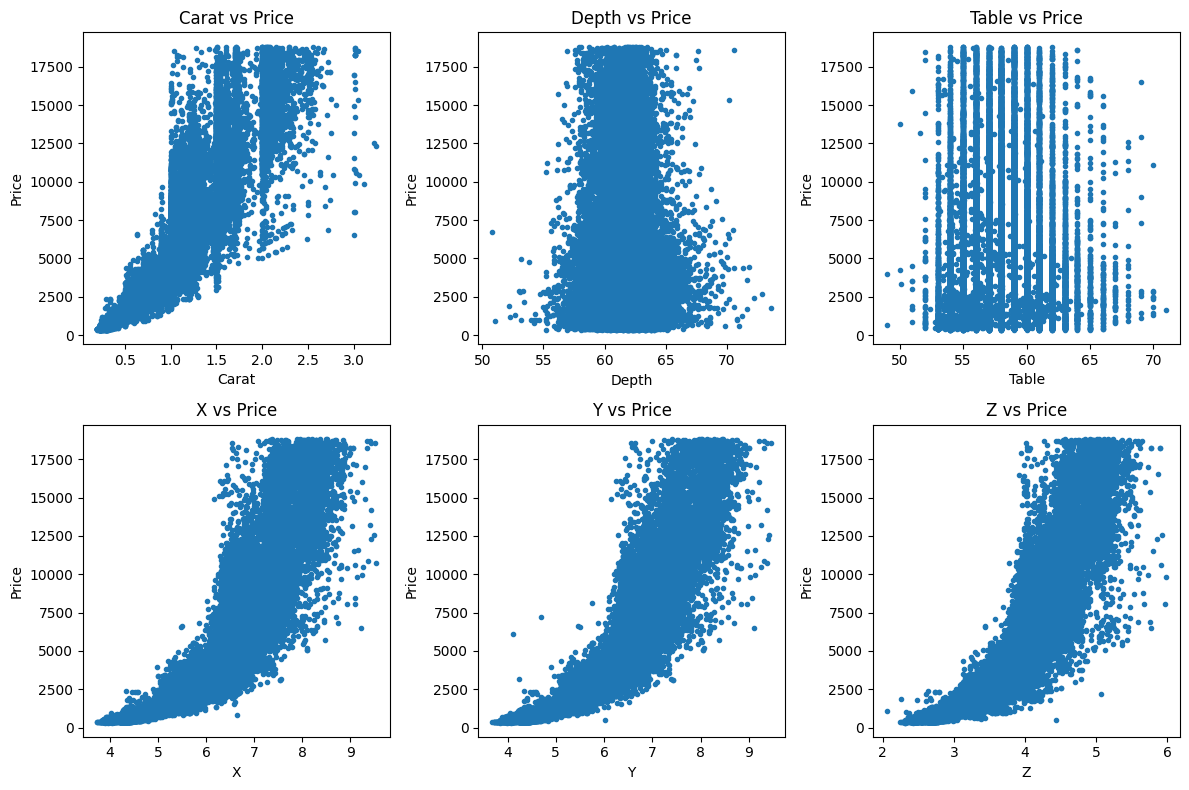

In [6]:
plot_statistics()

Eftersom vi sparade hur mycket data om fanns från början kan vi nu skriva ut hur mycket som sorterats bort.

In [7]:
current_len = df.shape[0]
print(f'{start_len - current_len} av {current_len} eller {(start_len - current_len) / start_len:.4f}% av datapunkter borttagna')

51 av 53889 eller 0.0009% av datapunkter borttagna


Det finns fortfarande några kolumner som har kategoriska värden (*cut*, *color*, *clarity*). Detta går inte att mata till modellen, så pd.get_dummies() används för att konvertera varje kolumn av kategoriska värden till enskilda kolumner för varje kategori och sedan används True och False för att markera vilken kategori som den raden hade. Kolumnerna med kategoriska värden tas bort efter att det enskilda kolumnerna har skapats.

In [8]:
print('Före:')
display(df.head())

encoded_df = pd.get_dummies(df, prefix_sep=': ')

print('Efter:')
display(encoded_df.head())

Före:


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Efter:


,carat,depth,table,price,x,y,z,cut: Fair,cut: Good,cut: Ideal,...,color: I,color: J,clarity: I1,clarity: IF,clarity: SI1,clarity: SI2,clarity: VS1,clarity: VS2,clarity: VVS1,clarity: VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,False,True,False,...,False,True,False,False,False,True,False,False,False,False


## 2. Skapa en modell

Nu är det dags att bygga en modell. I detta projektet används en eXtreme Gradient Booster. Det bygger på att iterativt bygga Decision Tree modeller och varje iteration förbättra från den förra. 

Först delas datan upp för träning och testning. Delningen är 0.2, alltså blir 80% träning och 20% testning.

In [9]:
X = encoded_df.drop(columns='price')
y = encoded_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Vi skapar den mest grundläggande versionen som går och testar hur bra den fungerar.

In [10]:
model = xgb.XGBRegressor(random_state=2)
model.fit(X_train, y_train);

Nu kan vi göra lite visualisering om hur bra den är. På graferna kan vi också rita en linje som visar vart punkterna ska vara i bästa fall. I första grafen är det där modellens förusägelse är samma som det riktiga priset. I den andra grafen så är det där deltat mellan modellen och det riktiga priset är noll. Med funktionen skriver vi också ut det vanliga värdena MAE, MSE, RMSE.

Mean Absolute Error (MAE):      282
Mean Squared Error (MSE):       282758
Root Mean Squared Error (RMSE): 532


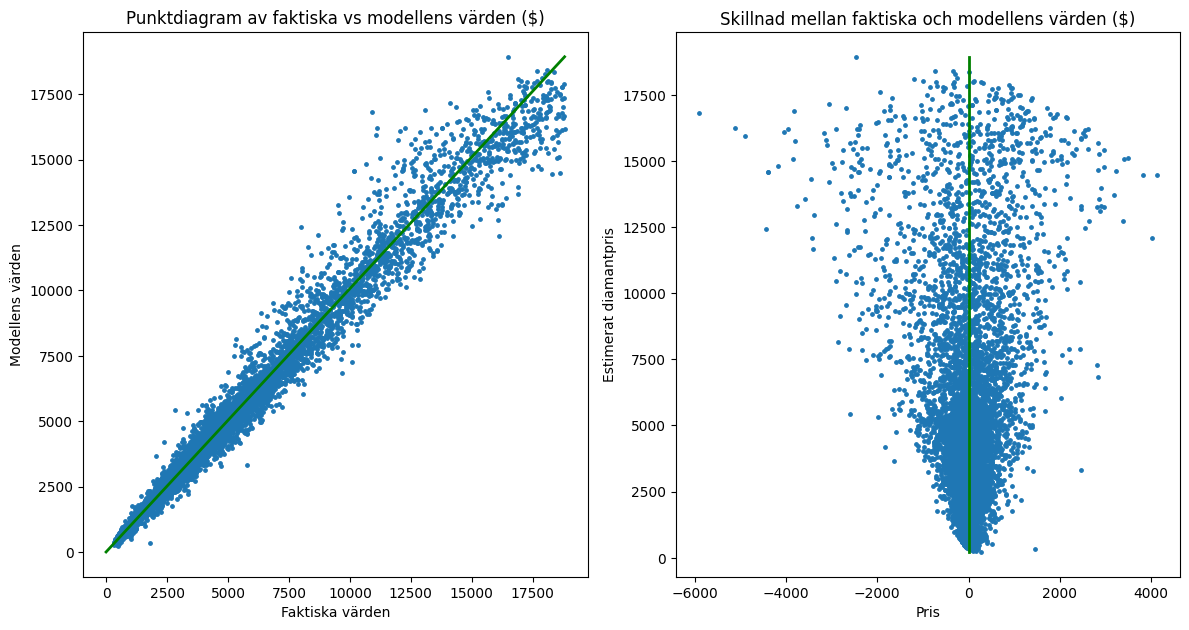

In [11]:
def plot_perf(model):
    '''Skapa en grafer som visar modellens prestanda'''

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (MAE):      {mae:.0f}')
    print(f'Mean Squared Error (MSE):       {mse:.0f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.0f}')

    # Punktdiagram (faktiskt vs modell)
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, s=6)
    plt.plot([0, max(y_test)], [0, max(y_pred)], 'g', linewidth=2)
    plt.xlabel('Faktiska värden')
    plt.ylabel('Modellens värden')
    plt.title('Punktdiagram av faktiska vs modellens värden ($)')

    # Punktdiagram (fel)
    difference = y_test - y_pred
    plt.subplot(2, 2, 2)
    plt.scatter(difference, y_pred, s=6)
    plt.plot([0, 0], [min(y_pred), max(y_pred)], 'g', linewidth=2)
    plt.xlabel('Pris')
    plt.ylabel('Estimerat diamantpris')
    plt.title('Skillnad mellan faktiska och modellens värden ($)')

    plt.tight_layout()

plot_perf(model)

# 3. Justera och förbättra
En sådan här modell kan ta väldigt många parametrar som alla påverkar dess precision. Det finns verktyg som är gjorda för att testa flera kombinationer för att hitta den bästa möjliga. Det två vanligaste är gridSearch och randomizedSearch. Grid testar all möjliga kombinationer, medans random testar slumpmässigt valda hyperparametrar ett bestämt antal gånger. Grid är garanterat att hitta den bästa modellen, men random kan hitta något fortfarande bra, på mycket färre försök.

Vi konfigurerar också early_stopping_rounds för att spara tid. Modellen kommer då stoppa träningen tidigt ifall modellen inte blir bättre under antalet iterationer som anges, i detta fallet 10. Det kräver dock att vi behöver dela datan igen för ett validations set att använda under träning.

In [12]:
X_search, X_val, y_search, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

param_dist = {
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5],   # Hur snabbt värden förändras vid varje iteration
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800],           # Antal steg att träna modellen

    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],                              # Maximalt djup för varje träd
    'min_child_weight': [1, 2, 3, 4, 5],                                    # Hur mycket som krävs för att trädet ska dela sig
    'gamma': [0, 1, 2, 3, 4, 5, 6],                                         # Minimum kravet på förbättring för att trädet ska dela sig

    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],                       # Andel av kolumnerna som tas med vid varje delning i trädet (förändringsfaktor)
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],                              # Andel av träningsdatan som tas med vid träningen av varje träd (förändringsfaktor)
}

print(f'Antal möjliga kombinationer: {math.prod(len(value) for value in param_dist.values()):,}')

rs = RandomizedSearchCV(
    xgb.XGBRegressor(
        early_stopping_rounds=10,
        random_state=2,
    ),
    param_dist,
    n_iter=250,
    n_jobs=-1,
    random_state=2
)

Antal möjliga kombinationer: 918,540


Nu kan vi köra randomizedSearch. Funktionen kallas inom en with statement för att plocka upp en del onödig output.

In [13]:
with redirect_stdout(StringIO()):
    rs.fit(
        X_search,
        y_search,
        eval_set=[(X_val, y_val)]
    )

Med randomizedSearch har vi nu testat 250 kombinationer av hyperparametrar. GridSearch hade gjort 918 540. Nu ska vi se hur bra den här modellen är.

Mean Absolute Error (MAE):      274
Mean Squared Error (MSE):       272977
Root Mean Squared Error (RMSE): 522


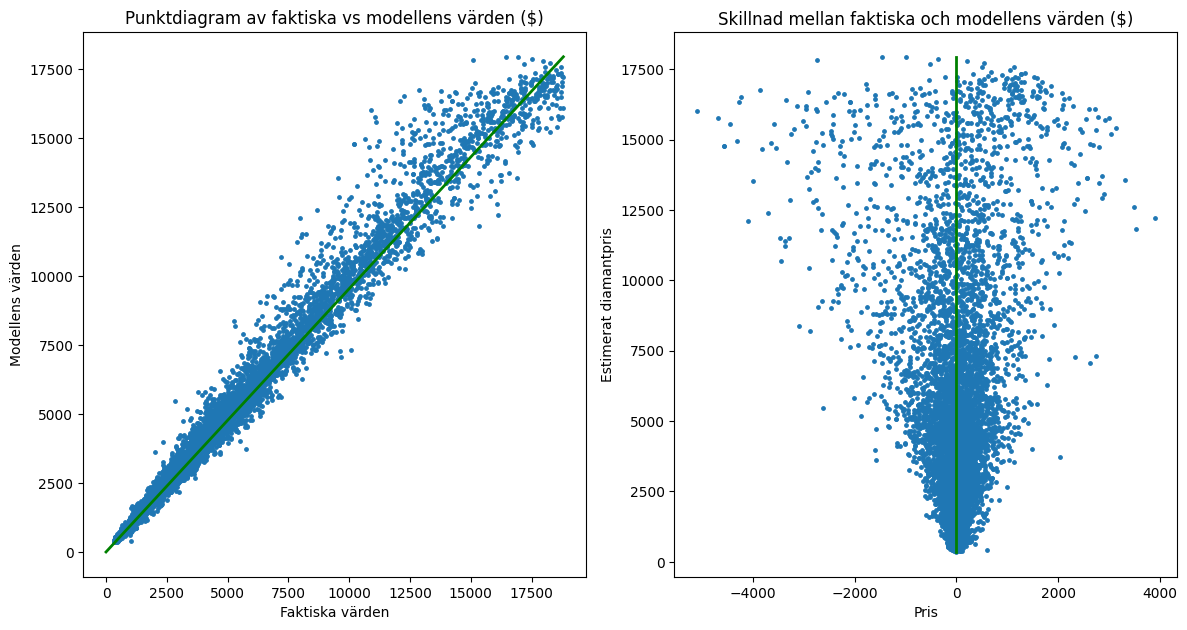

In [14]:
plot_perf(rs.best_estimator_) 

Nu när vi har en bra modell kan vi spara den till models mappen. Det tar ändå en stund att köra randomizedSearch och det vill vi inte göra varje gång som modellen ska användas. Namnet blir en score som returneras av randomizedSearch. Ifall modelen inte är bättre än någon redan sparad så kommer den inte sparas.

In [15]:
def save_best_model(rs: RandomizedSearchCV) -> None:
    '''Spara modellen om den är bättre än tidigare sparad modell'''

    # Skapa en mapp för modeller om det inte finns en än
    if not os.path.exists('models'):
        os.mkdir('models')

    saved_scores = [float(file.rsplit('.', maxsplit=1)[0]) for file in os.listdir('models') if file.endswith('.ubj')]

    best_saved = max(saved_scores) if saved_scores else 0

    if rs.best_score_ > best_saved:
        rs.best_estimator_.save_model(f'models/{rs.best_score_}.ubj')
        print('Modellen är bättre och har sparats')

save_best_model(rs)

# 4. Demo

Det är alltid kul att titta på några riktiga förutsägelser med den bästa modellen som finns. Först laddar vi in den bästa sparade modellen.

In [16]:
def load_best_model() -> xgb.Booster:
    '''Ladda in den bästa sparade modellen'''

    best_score = max(float(file.rsplit('.', maxsplit=1)[0]) for file in os.listdir('models') if file.endswith('.ubj'))

    best_model = xgb.XGBRegressor()
    best_model.load_model(f'models/{best_score}.ubj')

    return best_model

best_model = load_best_model()

Nu kan vi välja några slumpvis rader inom datan och göra några förutsägelser. Dessutom återställs indexen av av de radar som slumpvis valdes för att sedan kunna sammanfogas.

In [17]:
indices = np.random.choice(df.shape[0], 10, False)

df_demo = df.iloc[indices].reset_index(drop=True)
X_demo = X.iloc[indices].reset_index(drop=True)
y_demo = y.iloc[indices].reset_index(drop=True)

preds = best_model.predict(X_demo)

df_demo.drop(columns=['price'], inplace=True)
y_demo = pd.DataFrame({'actual price': y_demo})
preds_demo = pd.DataFrame({'predicted price': preds}).round().astype('int')

Till slut så lägger vi ihop värdena i en DataFrame och kör .capitalize() för bättre visualisering.

In [18]:
demo = pd.concat((df_demo, y_demo, preds_demo), axis=1)
demo.columns = [col.capitalize() for col in demo.columns]

display(demo)

,Carat,Cut,Color,Clarity,Depth,Table,X,Y,Z,Actual price,Predicted price
0,0.61,Very Good,E,SI1,63.3,60.0,5.36,5.29,3.37,1726,1842
1,2.03,Premium,J,SI2,61.6,58.0,8.15,8.12,5.01,12380,12371
2,0.72,Ideal,F,VS1,62.5,54.0,5.73,5.76,3.59,3330,3272
3,1.91,Very Good,F,SI1,62.2,54.0,7.91,7.97,4.94,17509,16209
4,1.76,Ideal,G,VS1,62.8,55.0,7.74,7.70,4.85,18178,17005
5,1.13,Premium,G,VVS1,59.3,59.0,6.79,6.87,4.05,8709,9284
6,0.53,Ideal,D,VS2,61.4,56.0,5.20,5.23,3.20,1857,1854
7,1.00,Fair,H,VS1,57.4,68.0,6.52,6.47,3.73,4368,4937
8,0.70,Very Good,H,SI1,60.9,62.0,5.67,5.72,3.47,2066,2132
9,1.01,Very Good,G,SI1,62.4,58.0,6.39,6.44,4.00,4653,5004
